<a href="https://colab.research.google.com/github/ushakiet01/FMML_PROJECTS_AND_ASSIGNMENTS/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [11]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [12]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-13 15:35:28--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.172.170.43, 18.172.170.106, 18.172.170.8, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.172.170.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip.1’

hymenoptera_data.zi 100%[===================>]  45.10M   291MB/s    in 0.2s    

2024-05-13 15:35:28 (291 MB/s) - ‘hymenoptera_data.zip.1’ saved [47286322/47286322]

replace hymenoptera_data/train/ants/0013035.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


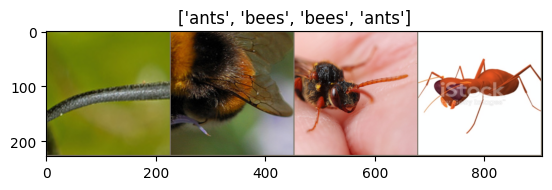

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.5276 Acc: 0.7049

Epoch 1/4
----------
Loss: 0.4534 Acc: 0.8033

Epoch 2/4
----------
Loss: 0.6705 Acc: 0.7377

Epoch 3/4
----------
Loss: 0.5762 Acc: 0.7541

Epoch 4/4
----------
Loss: 0.5634 Acc: 0.7623



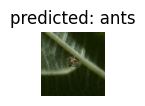

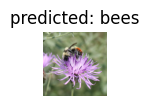

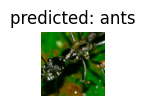

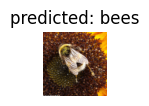

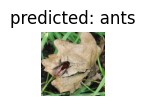

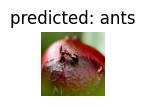

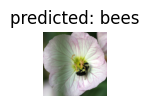

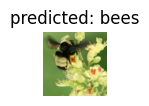

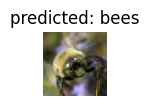

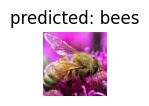

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


1. What is the significance of using data augmentations like resize, crop etc on training data?


Data augmentation techniques like resizing, cropping, flipping, rotating, and adding noise to training data serve several important purposes in machine learning, particularly in tasks like image classification:

Increased Robustness: Data augmentation introduces diversity into the training data, making the model more robust to variations it might encounter in real-world scenarios. By presenting the model with different versions of the same data, it learns to generalize better and becomes less sensitive to small changes in the input.

Improved Generalization: Data augmentation helps prevent overfitting by exposing the model to a broader range of variations within the training data. Overfitting occurs when the model learns to memorize the training examples rather than learning general patterns, and data augmentation helps mitigate this by providing a more diverse set of training samples.

Reduced Memorization: When a model is trained on a limited dataset without augmentation, it may inadvertently memorize specific details of the training examples rather than learning the underlying patterns. Data augmentation disrupts this memorization process by presenting the model with variations of the same data, forcing it to focus on the essential features for classification rather than memorizing specific instances.

Addressing Class Imbalance: In classification tasks where certain classes have significantly fewer samples than others (class imbalance), data augmentation can be used to generate synthetic samples for the underrepresented classes. This helps balance the distribution of classes in the training data and improves the model's ability to learn from all classes equally.

Regularization: Data augmentation serves as a form of regularization by adding noise to the training process. Regularization techniques help prevent the model from fitting noise in the training data and encourage it to learn more robust and generalizable features.

Overall, data augmentation is a crucial technique for improving the performance and generalization capabilities of machine learning models, particularly in tasks where labeled training data is limited or when the goal is to build models that can perform well in real-world scenarios with diverse inputs.




2.What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

If you train a ResNet model from scratch without using pre-trained weights (by setting pretrained=False), the performance might be significantly lower compared to using pre-trained weights.

Here are some potential outcomes:

Lower Accuracy: Training a deep neural network like ResNet from scratch requires a large amount of labeled data and computational resources. Without pre-trained weights, the model starts with random initialization, and it needs to learn features from scratch. This often leads to lower accuracy because the model may struggle to converge to a good solution, especially if the dataset is small or if training resources are limited.

Longer Training Time: Training a deep neural network from scratch typically requires more epochs and longer training time compared to fine-tuning a pre-trained model. Since the model needs to learn features from scratch, it may take more time to converge to a satisfactory solution, especially if the dataset is complex or if the model architecture is deep.

Potential Overfitting: Without the regularization effect of pre-trained weights, the model may be more prone to overfitting, especially if the dataset is small or if the model architecture is complex. Overfitting occurs when the model memorizes the training data instead of learning generalizable features, leading to poor performance on unseen data.

Sensitivity to Initialization: The performance of a model trained from scratch can be sensitive to the random initialization of weights. Small changes in initialization can lead to significantly different final performance, making it harder to reproduce results or compare different training runs.

In summary, while it's possible to train a ResNet model from scratch without using pre-trained weights, it often results in lower performance, longer training time, and a higher risk of overfitting, especially in scenarios with limited data or computational resources.





3. If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?

The performance of a pre-trained ResNet model on a new dataset, such as the ants vs. bees dataset, depends on several factors:

Domain Similarity: If the pre-trained ResNet model was trained on a dataset that is significantly different from the ants vs. bees dataset in terms of domain, style, or content, the performance might be adversely affected. This is because the features learned by the pre-trained model may not be directly relevant or transferable to the new dataset.

Task Similarity: The performance of the pre-trained model also depends on the similarity between the tasks of the original dataset and the new dataset. If the pre-trained model was trained on a dataset with similar classification tasks (e.g., object recognition), it is more likely to perform well on the new dataset compared to a model trained on a completely unrelated task.

Feature Reusability: Deep learning models, including ResNet, learn hierarchical representations of features that can be transferable across different tasks and datasets to some extent. Even if the pre-trained model was trained on a different dataset, lower-level features (e.g., edges, textures) might still be useful for the new dataset. However, higher-level features (e.g., object shapes, semantics) might not transfer as effectively if the datasets are significantly dissimilar.

Fine-Tuning and Adaptation: To improve the performance of the pre-trained model on the new dataset, fine-tuning or transfer learning techniques can be applied. By fine-tuning the pre-trained model on the new dataset, the model can adapt its learned features to better suit the characteristics of the new data, potentially leading to improved performance.

In conclusion, while using a pre-trained ResNet model on a dataset like ants vs. bees might provide a useful starting point and some transferable features, the performance may not be optimal if the pre-trained model was trained on a significantly different dataset. Fine-tuning and adaptation techniques can help improve the model's performance by leveraging the pre-trained features and adapting them to the new dataset.





